# Joint Optimization of Masks and Deep Recurrent Neural Networks for Monaural Source Separation
## Implementation and Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from itertools import islice

import os
import numpy as np
import tensorflow as tf
import python_speech_features as psp
import IPython
from IPython.display import Audio, display
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt
import python_speech_features as psf

from features.wav_iterator import batcher, wav_iterator
from features.wav_iterator import lmf_iterator, stft_iterator
from features.feat_iterator import lmf_stft_iterator

from features.spectral_features import stft, istft

audio_dir = os.environ['AUDIO_PATH']

## Data

In [2]:
sig_length = 30
stft_step = 512
stft_len = 1024
sig_length_samples =(sig_length-1)*stft_step+stft_len
freq_extent = stft_len // 2 + 1
fs = 16000
lmf_filters = 90
print(sig_length_samples)

15872


In [3]:
def plot_mix(src1, src2, mix, rot=True, cmap="bone", aspect=4):
    """
    Plot original data
    """
    plt.figure(figsize=(15,10))
    ax = plt.subplot(1,4,1)
    if rot:
        org = 'bottom'
        src1 = src1.T
        src2 = src2.T
        mix = mix.T
        aspect = 1/aspect
    else:
        org = 'top'
    
    ax.set_title("Truth A")
    im = ax.matshow(src1, cmap=cmap, interpolation='bilinear', origin = org, aspect=aspect)
    plt.colorbar(im, shrink=0.25)
    ax = plt.subplot(1,4,2)
    ax.set_title("Truth B")
    im = ax.matshow(src2, cmap=cmap, interpolation='bilinear', origin = org, aspect=aspect)
    plt.colorbar(im, shrink=0.25)
    ax = plt.subplot(1,4,3)
    ax.set_title("Mix")
    im =ax.matshow(mix, cmap=cmap, interpolation='bilinear', origin = org, aspect=aspect)
    plt.colorbar(im, shrink=0.25)


def plot_recons(src_recon1, src_recon2, rot=True, cmap="bone", aspect=4):
    """
    Plot reconstructions
    """
    if rot:
        org = 'bottom'
        src_recon1 = src_recon1.T
        src_recon2 = src_recon2.T
        aspect = 1/aspect
    else:
        org = 'top'
        
    plt.figure(figsize=(15,10))
    ax = plt.subplot(1,3,1)
    ax.set_title("Recon A")
    im = ax.matshow(src_recon1, cmap=cmap, interpolation='bilinear', origin = org, aspect=aspect)
    plt.colorbar(im, shrink=0.5)
    ax = plt.subplot(1,3,2)
    ax.set_title("Recon B")
    im = ax.matshow(src_recon2, cmap=cmap, interpolation='bilinear', origin = org, aspect=aspect)
    plt.colorbar(im, shrink=0.5)
    
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n    

STFT all real:  False


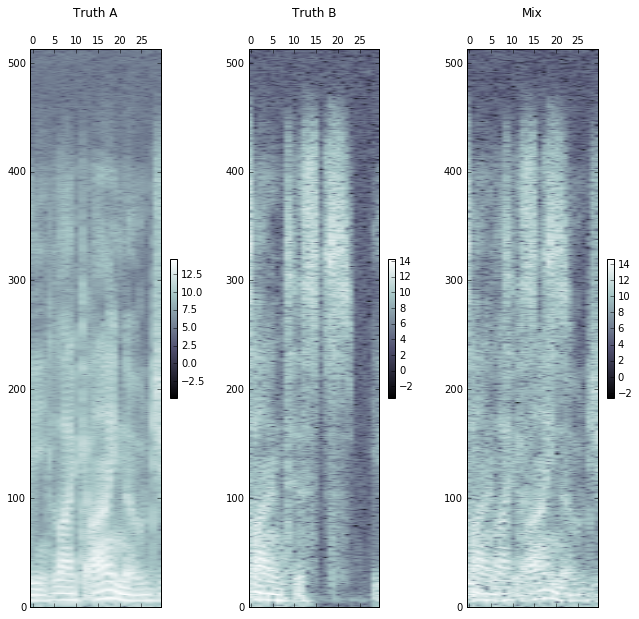

Mix features (Log mel filters)


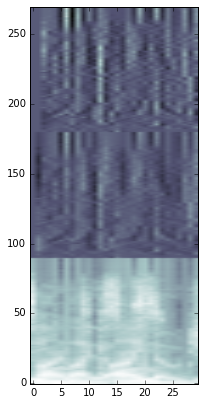

In [44]:
wavs = wav_iterator(audio_dir, sig_length=sig_length_samples)
features = lmf_stft_iterator(wavs, stft_len=stft_len, stft_step=stft_step, 
                             nfilters=lmf_filters, use_diffs=True, return_onesided=True)

m, t = next(features)

# Take log-magnitude spectrograms of truth signals and mix
print("STFT all real: ", (np.square(t[0]) >= 0.0).all())
s1 = np.log(np.absolute(t[0])).real
s2 = np.log(np.absolute(t[1].real))
mix = np.log(np.absolute(t[2].real))
plot_mix(s1, s2, mix, True)
plt.show()
print("Mix features (Log mel filters)")
plt.figure(figsize=(3,10))
plt.imshow(m.T, cmap='bone', aspect=1/4, origin='bottom')
plt.show()

## Implementation of the network

The network diagram from Huang et al. is useful:
![Joint Optimization of Masks and Deep RNNs diagram](../../data/pictures/mask-rnn.png)

There are three feed-forward layers after the input. One (the second) has recurrent connections. After the third layer the network splits into two and computes two "soft" masks $\hat{y}_1$ and $\hat{y}_2$. The final layer $\bf{z}_t$ is the magnitude component of the input STFT, which is multiplied elementwise with the mask to yield the reconstruction.

![Joint Optimization of Masks and Deep RNNs masking op](../../data/pictures/mask-rnn-mask.png)


### Tensorflow Implementation

In [5]:
def scope(function):
    attribute = '_cache_' + function.__name__
    name = function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self,attribute):
            with tf.variable_scope(name):
                setattr(self,attribute,function(self))
        return getattr(self,attribute)
    
    return decorator


In [6]:
batch_size = 64
num_steps = sig_length
input_shape = lmf_filters * 3
output_shape = freq_extent
ff1_size = 180
recurrent_size = 100
ff2_size = 140
truth_size = 3
mix_idx = truth_size - 1

In [9]:
tf.reset_default_graph()
try:
    sess.close()
except:
    pass
finally:
    sess = tf.Session()
    
with tf.variable_scope(tf.get_variable_scope()) as vscope:
    with tf.device("/gpu:0"):
        with sess.as_default():
            audio_features = tf.placeholder(tf.float32, shape=(None, num_steps, input_shape), 
                                            name="audio_features")
            audio_truth = tf.placeholder(tf.float32, shape=(None, truth_size, num_steps, output_shape), 
                                         name="audio_truth")
            
            ## Set up network #########
            # Feedforward 1
            with tf.variable_scope('feedforward'):
                feedforward_weights = tf.get_variable("dense_wts_1", 
                                                      initializer=tf.random_normal_initializer(stddev=0.1), 
                                                      shape=(input_shape, ff1_size))
                feedforward_bias = tf.get_variable("dense_bias_1", 
                                                   initializer=tf.zeros_initializer(),
                                                   shape=(1, ff1_size))
            # Recurrent layer
            with tf.variable_scope('recurrent'):
                recurrent_cell = tf.contrib.rnn.BasicLSTMCell(recurrent_size)
                #recurrent_cell = tf.contrib.rnn.BasicRNNCell(recurrent_size)
                recurrent_state = recurrent_cell.zero_state(batch_size, audio_features.dtype)
            # Feedforward 2
            feedforward_2_weights = tf.Variable(tf.random_normal((recurrent_size, ff2_size), stddev=0.1), 
                                                name="dense_wts_2")
            feedforward_2_bias = tf.Variable(tf.zeros((1, ff2_size)), name="dense_bias_2")
            # Preconstruction a (y_hat)
            mask_a_weights = tf.Variable(tf.random_normal((ff2_size, output_shape), stddev=0.1), 
                                         name="mask_a_weights")
            mask_a_bias = tf.Variable(tf.zeros((1, output_shape)), name="mask_a_bias")
            # Preconstruction b
            mask_b_weights = tf.Variable(tf.random_normal((ff2_size, output_shape), stddev=0.1), 
                                         name="mask_b_weights")
            mask_b_bias = tf.Variable(tf.zeros((1, output_shape)), name="mask_b_weights")
            
            ## Set up operations #######
            recons = {'a':[], 'b': []}

            # normalize features
            #TODO: shouldn't this not collapse over batches?
            af_mean, af_var = tf.nn.moments(audio_features, axes=[0, 1, 2])
            audio_features_norm = (audio_features - af_mean) / tf.sqrt(af_var)
            
            #af_mag = tf.abs(audio_features)
            # Normalize over batch, time and frequency; not over sample
            at_mean, at_var = tf.nn.moments(audio_truth, axes=[0, 2, 3], keep_dims=True)
            audio_truth_norm = (audio_truth - at_mean) / tf.sqrt(at_var)
            
            # list of mask tensors
            mask_0 = []
            # list of pretrainable ops
            #pretrain_endpoints = []
            # accumulate recurrent outputs
            #recurrent_outputs = []
            # Design journal:
            # Time steps loop around the whole net or just
            # The recurrent bit?
            # Should just be a broadcastable op for everything but the recurrent layer
            #tf.get_variable_scope().reuse_variables()
            # Feedforward 1 ops
            print(audio_features_norm)
            print(feedforward_weights)
            audio_features_norm_2d = tf.reshape(audio_features_norm, (-1, input_shape))
            feedforward_out = tf.matmul(audio_features_norm_2d,feedforward_weights) + feedforward_bias
            print(feedforward_out)
            feedforward_out = tf.nn.relu(feedforward_out)
            feedforward_out = tf.reshape(feedforward_out, (-1, num_steps, ff1_size))
            #pretrain_endpoints.append(feedforward_out)
            print(feedforward_out)
            # Recurrent ops
#             for input_time in range(num_steps):
#                 recurrent_output, recurrent_state = recurrent_cell(feedforward_out, recurrent_state)
#                 recurrent_output = tf.nn.relu(recurrent_output)
#                 recurrent_outputs.append(recurrent_output)
#                 if input_time<2:
#                     print(recurrent_output)
#                     print(recurrent_state)
            # Use dynamic_rnn interface
            with tf.variable_scope("recurrent", reuse=None):
                recurrent_outputs, recurrent_state = tf.nn.dynamic_rnn(recurrent_cell, 
                                                                       feedforward_out, 
                                                               dtype=feedforward_out.dtype)
            recurrent_outputs = tf.reshape(recurrent_outputs, (-1, recurrent_size))
            # Feedforward 2 ops
            feedforward_2_out = tf.matmul(recurrent_outputs,feedforward_2_weights) + feedforward_2_bias
            print(feedforward_2_out)
            feedforward_2_out = tf.nn.relu(feedforward_2_out)

            # Soft Mask a/b
            with tf.variable_scope("masks"):
                mask_a = tf.matmul(feedforward_2_out,mask_a_weights) + mask_a_bias
                mask_b = tf.matmul(feedforward_2_out,mask_b_weights) + mask_b_bias
                mask_0.append(mask_a)
            mask_a_raw = tf.reshape(mask_a, (batch_size, num_steps, output_shape))
            mask_b_raw = tf.reshape(mask_b, (batch_size, num_steps, output_shape))
            print("Mask size: ")
            print(mask_a)
            print(mask_b)
            # Apply mask for final reconstruction
            mask_a = tf.abs(mask_a_raw) / (tf.abs(mask_a_raw)+tf.abs(mask_b_raw))
            mask_b = tf.abs(mask_b_raw) / (tf.abs(mask_a_raw)+tf.abs(mask_b_raw))
            recon_a = tf.multiply(mask_a, audio_truth_norm[:, mix_idx])
            recon_b = tf.multiply(mask_b, audio_truth_norm[:, mix_idx])
            out_pair = tf.stack((recon_a,recon_b), axis=1)
            
            print(out_pair)
            print(audio_truth[:,:mix_idx])
            # Allow loss to be from A->A, B->B or A->B, B->A (will not scale for higher nrs of speakers!)
            # involves allowing different permutations for each example
            # i.e. not gonna be all forwards or backwards for a given minibatch
            loss_a = tf.reduce_mean(tf.squared_difference(out_pair, audio_truth_norm[:,:mix_idx]), axis=(1,2,3))
            loss_b = tf.reduce_mean(tf.squared_difference(out_pair[:, ::-1], audio_truth_norm[:,:mix_idx]), axis=(1,2,3))
            mask_sparsity = tf.reduce_mean(tf.abs(mask_a)) + tf.reduce_mean(tf.abs(mask_b))
            loss = tf.reduce_mean(tf.minimum(loss_a,loss_b)) + 0.25 * mask_sparsity
            
            # this means that reconstructions actually depend on different input
            # normalization statistics depending which permutation of the loss function 
            # was activated. headache!
            print(loss_a)
            combined_losses = tf.stack((loss_a, loss_b), axis=1)
            print(combined_losses)
            a_recon_mask = tf.cast(tf.argmax(combined_losses, axis=1), tf.float32)
            # expand dims
            a_recon_mask = a_recon_mask[:, tf.newaxis, tf.newaxis]
            # take complement for the other mask
            b_recon_mask = 1 - a_recon_mask
            
            # the argmin/max of the loss is an indicator variable pointing at which
            # normalization statistics are appropriate for a given example, 
            # so we can apply both sets of statistics, mask them with the argmin/max, and sum the results
            real_recon_a = a_recon_mask * (recon_a * at_var[:, 0] + at_mean[:, 0]) + \
                           b_recon_mask * (recon_a * at_var[:, 1] + at_mean[:, 1])
            real_recon_b = b_recon_mask * (recon_b * at_var[:, 1] + at_mean[:, 1]) + \
                           a_recon_mask * (recon_b * at_var[:, 0] + at_mean[:, 0])
#             real_recon_a = recon_a[:, tf.newaxis, :, :] * at_var[:] + at_mean[:]
#             real_recon_b = recon_b[:, tf.newaxis, :, :] * at_var[:] + at_mean[:]
            # alternatively we could have just used the normalization statistics for 
            # the mixture? this is what would happen in inference...

Tensor("truediv:0", shape=(?, 30, 270), dtype=float32, device=/device:GPU:0)
Tensor("feedforward/dense_wts_1/read:0", shape=(270, 180), dtype=float32, device=/device:GPU:0)
Tensor("add:0", shape=(?, 180), dtype=float32, device=/device:GPU:0)
Tensor("Reshape_1:0", shape=(?, 30, 180), dtype=float32, device=/device:GPU:0)
Tensor("add_1:0", shape=(?, 140), dtype=float32, device=/device:GPU:0)
Mask size: 
Tensor("masks/add:0", shape=(?, 513), dtype=float32, device=/device:GPU:0)
Tensor("masks/add_1:0", shape=(?, 513), dtype=float32, device=/device:GPU:0)
Tensor("stack:0", shape=(64, 2, 30, 513), dtype=float32, device=/device:GPU:0)
Tensor("strided_slice_2:0", shape=(?, 2, 30, 513), dtype=float32, device=/device:GPU:0)
Tensor("Mean:0", shape=(64,), dtype=float32, device=/device:GPU:0)
Tensor("stack_1:0", shape=(64, 2), dtype=float32, device=/device:GPU:0)


#### Feed-forward and loss calculation

In [10]:
# Unending iterator


#### Pretraining

#### Real Training

In [11]:
# Optimization loop
with sess.as_default():
    learning_rate = tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    descent_step = optimizer.minimize(loss)
    tf.global_variables_initializer().run()
    losses = []
    

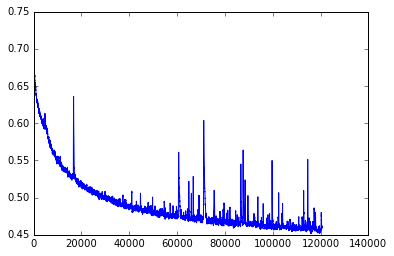

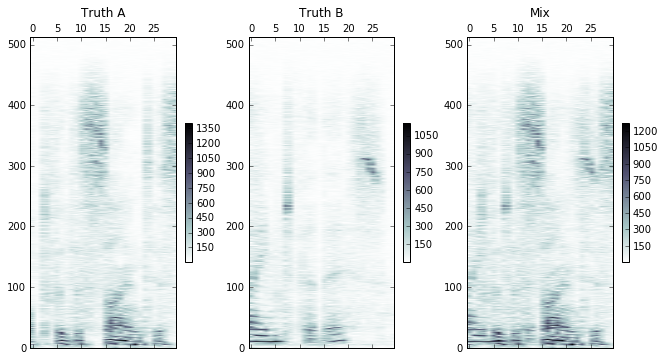

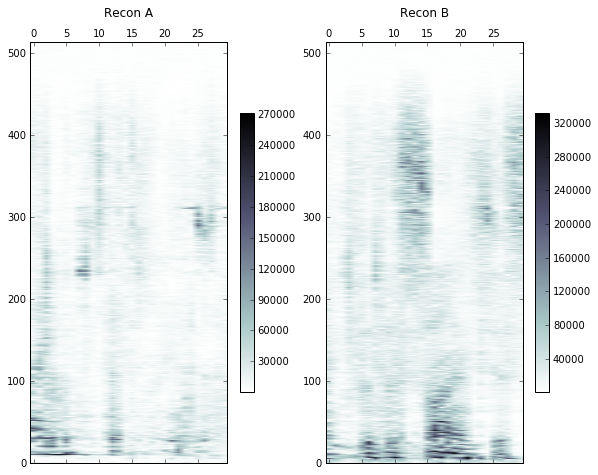

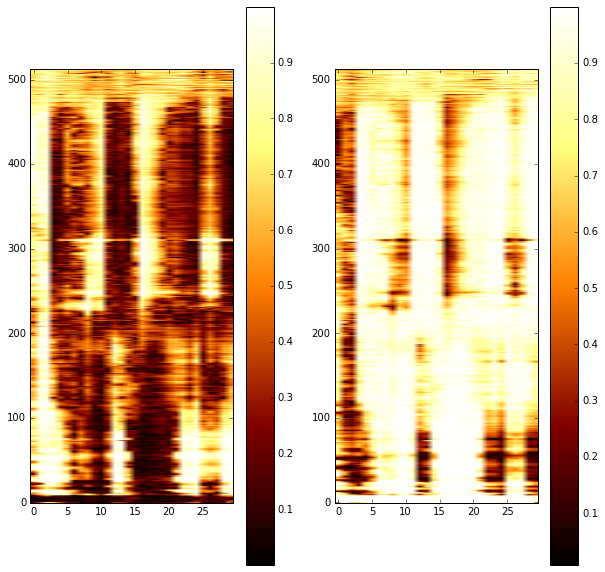

Truth A


Truth B


Mix


Recon A


Recon B


KeyboardInterrupt: 

In [46]:
num_batches = 100000

wavs = wav_iterator(audio_dir, sig_length=sig_length_samples)
features = lmf_stft_iterator(wavs, stft_len=stft_len, stft_step=stft_step, 
                             nfilters=lmf_filters, use_diffs=True, return_onesided=True)
batches = batcher(features, batch_size=batch_size)

with sess.as_default():
    for features, truth in islice(batches, num_batches):
        with open("learning_rate.txt") as f:
            data = {audio_features: features,
                    audio_truth: truth,
                    learning_rate: float(f.read().strip()) }
        descent_step.run(feed_dict=data)        
        losses.append(loss.eval(feed_dict=data))
        if np.isnan(losses[-1]):
            raise ValueError("NaN loss")
            
        # Visualization    
        if len(losses) % 40 == 0:
            src_a_c, src_b_c, mix_c = truth[0][0], truth[0][1], truth[0][mix_idx]
            src_a, src_b, mix = truth[0][0].real, truth[0][1].real, truth[0][mix_idx].real
#             ex_a, ex_b = real_recon_a[0][0].eval(data), real_recon_b[0][0].eval(data)
            ex_a, ex_b = real_recon_a[0].eval(data), real_recon_b[0].eval(data)
            mask_a_img, mask_b_img = mask_a[0].eval(data).T, mask_b[0].eval(data).T

            # Audio reconstruction
            mix_audio = istft(np.absolute(mix_c) 
                                  * np.exp(1j * np.unwrap(np.angle(mix_c))), fs=1, 
                       recon_size=sig_length_samples, hop=stft_step, two_sided=False)
            truth_a_audio = istft(np.absolute(src_a_c) 
                                  * np.exp(1j * np.unwrap(np.angle(mix_c))), fs=1, 
                       recon_size=sig_length_samples, hop=stft_step, two_sided=False)
            recon_a_audio = istft(np.absolute(ex_a) 
                                  * np.exp(1j * np.unwrap(np.angle(mix_c))), fs=1, 
                       recon_size=sig_length_samples, hop=stft_step, two_sided=False)
            truth_b_audio = istft(np.absolute(src_b_c) 
                                  * np.exp(1j * np.unwrap(np.angle(mix_c))), fs=1, 
                       recon_size=sig_length_samples, hop=stft_step, two_sided=False)
            recon_b_audio = istft(np.absolute(ex_b) 
                                  * np.exp(1j * np.unwrap(np.angle(mix_c))), fs=1, 
                       recon_size=sig_length_samples, hop=stft_step, two_sided=False)
            IPython.display.clear_output(wait=True)
            
            # Plot loss curve
            #plot_start = int(len(losses) * 0.1)
            plot_start = 0
            plt.plot(moving_average(losses[plot_start:], 100))
            
            # pull out an example and plot it
            # what is the truth?
            plot_mix(np.sqrt(np.absolute(src_a)), 
                     np.sqrt(np.absolute(src_b)), 
                     np.sqrt(np.absolute(mix)), 
                     cmap='bone_r',aspect=8)
            plot_recons(np.sqrt(np.absolute(ex_a)), 
                        np.sqrt(np.absolute(ex_b)),
                       aspect=8, cmap='bone_r')
            

            # Masks
            plt.figure(figsize=(10,10))
            plt.subplot(1,2,1)
            plt.imshow(np.sqrt(mask_a_img), origin='bottom', cmap='afmhot', aspect=1/8)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(np.sqrt(mask_b_img), origin='bottom', cmap='afmhot', aspect=1/8)
            plt.colorbar()
            plt.show()
            
            
            print('Truth A')
            display(Audio(truth_a_audio, rate=fs))
            print('Truth B')
            display(Audio(truth_b_audio, rate=fs))
            print('Mix')
            display(Audio(mix_audio, rate=fs))
            
            print('Recon A')
            display(Audio(recon_a_audio, rate=fs))

            print('Recon B')
            display(Audio(recon_b_audio, rate=fs))


In [ ]:
sess.run(tf.minimum(tf.reduce_mean(tf.squared_difference(out_pair, audio_truth_norm[:,mix_idx-1::-1]), axis=(1,2,3)),
         tf.reduce_mean(tf.squared_difference(out_pair, audio_truth_norm[:,:mix_idx]), axis=(1,2,3))), data)

In [14]:
mix_c.shape

(30, 513)

In [20]:
ex_a.shape

(513,)

In [21]:
real_recon_a.shape

TensorShape([Dimension(64), Dimension(30), Dimension(513)])

In [18]:
recon_a.shape

TensorShape([Dimension(64), Dimension(30), Dimension(513)])

In [23]:
mask_a_img.shape

(513, 30)

In [15]:
#sess.run(real_recon_b, data).shape
sess.run(at_var, data).shape

/opt/conda/envs/magnolia3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1, 3, 1, 1)